#Problemas de la guía 5
## S. Schiavinato - LU 153/11

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)) / 2, 5)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 20

Datos para ambos problemas

In [101]:
σ = 0.3
X = np.array([2.00,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3.00])
Y = np.array([2.78,3.29,3.29,3.33,3.23,3.69,3.46,3.87,3.62,3.40,3.99])

Ajustes por cuadrados mínimos

In [6]:
def cuadrados_minimos(X, Y, σY):
    N = X.size
    Δ = N * np.sum(X**2) - np.sum(X)**2
    A1 = (np.sum(X**2) * np.sum(Y) - np.sum(X) * np.sum(X*Y))/Δ
    A2 = (N * np.sum(X*Y) - np.sum(X) * np.sum(Y))/Δ
    Σ11 = σY**2 / Δ * np.sum(X**2)
    Σ22 = σY**2/ Δ * N
    Σ12 = σY**2/Δ * (-np.sum(X))
    a = np.array([A1, A2])
    cov = np.array([[Σ11, Σ12],[Σ12, Σ22]])
    return a, cov

##Problema 6 
### Graficar los datos y ajustar una recta, con las bandas de error (con y sin covarianza considerada)

Considerando la covarianza entera

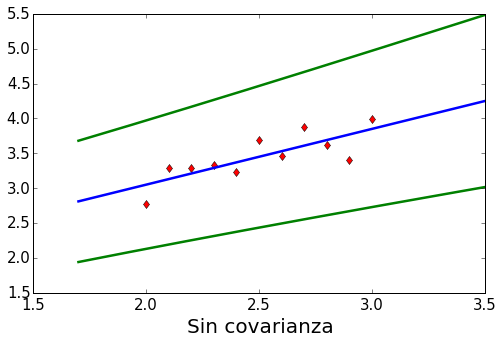

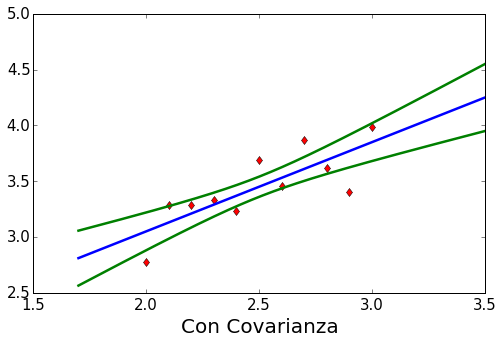

In [118]:
a, cov = cuadrados_minimos(X, Y, σ)

t = np.linspace(1.7, 3.5, 1000)
f = lambda x, a, b: a + b * x #Para ejecutarlo puedo usar f(t, *a) sii a es un lista o una tupla de dos elementos
σYCov = lambda x, cov : np.sqrt(cov[0,0] + x**2 * cov[1,1] + 2 * x * cov[0,1])
σY = lambda x, cov : np.sqrt(cov[0,0] + x**2 * cov[1,1])

#Sin covarianza
plt.figure(1)
plt.plot(X,Y,'rd')
plt.plot(t,f(t, *a) + σY(t, cov), 'g-')
plt.plot(t, f(t, *a), 'b-')
plt.plot(t, f(t, *a) - σY(t, cov), 'g-');
plt.xlabel("Sin covarianza")

#Con covarianza
plt.figure(2)
plt.plot(X,Y,'rd')
plt.plot(t,f(t, *a) + σYCov(t, cov), 'g-')
plt.plot(t, f(t, *a), 'b-')
plt.plot(t, f(t, *a) - σYCov(t, cov), 'g-');
plt.xlabel("Con Covarianza");

##Problema 7
### A partir de las rectas ajustadas, generar números al azar respecto al ajuste con distribución normal.

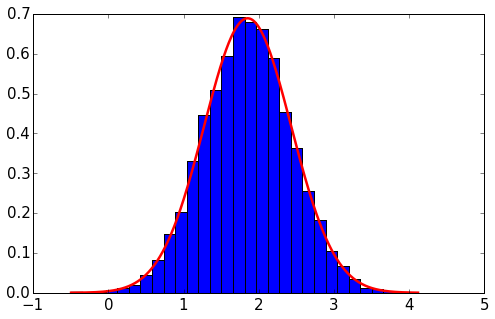

In [119]:
A = []
N = 10000 #Cantidad de cuentas
#El _ es un nombre válido para una variable, que se usa como dummy para guardar cosas no usadas
a, cov = cuadrados_minimos(X, Y, σ) #Calculo los parámetros, para ingresar al generador de numeros aleatorios
for i in range(N):
    Yr = []
    i = 0
    for x in np.nditer(X): #Creo un array Yr con valores aleatorios normales para cada x del vector X
        Yr.append(np.random.normal(f(x, *a), σ, 1))
    Yr = np.ravel(np.array(Yr))
    ar, covr = cuadrados_minimos(X, Yr, σ) #Uso cuadrado mínimos con los datos aleatorios y obtengo una nueva recta
    A.append(f(0.5, *ar)) #Guardo en un vector el valor predicho por el ajuste
A = np.array(A)
_ = plt.hist(A, bins = 30, normed = True); #Genero el histograma de los datos al azar
t = np.linspace(np.amin(A), np.amax(A), 1000) #Creo el vector t para graficar la gaussiana acorde
_ = plt.plot(t, stats.norm.pdf(t, f(0.5, *a), σYCov(0.5, cov)), 'r-'); #El error en y debe ser el propagado